In [5]:
#dependencies
import os
import h5py
import pylab as pl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy

import utils.conversions as cnv
import utils.plotutils as plu
import utils.movie_plotutils as mplu
import utils.imreadin as imr
import utils.readMov as rdm
import utils.movie_aec as aec
import utils.train_model as tm

import imp
imp.reload(rdm)
imp.reload(tm)
imp.reload(cnv)
imp.reload(mplu)
from random import shuffle

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

/home/vasha/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
imp.reload(rdm)
movie_name = 'cheetah'
pixelpatchsize = 8
framepatchsize = 30

colorinvert = False

#del m
with tf.device('/cpu:0'):
    try:
        m
        print('Movie Already Loaded.')
    except NameError:
        m = rdm.get_movie(movie_name,
                          pixel_patch_size = pixelpatchsize,
                          frame_patch_size = framepatchsize
                          )
        #m = np.transpose(m, (0, 3, 1, 2)) #change axis to [batchsize, time_patchsize, x_patchsize, y_patchsize]

        print("Movie Loaded. Shape is " + str(np.shape(m)))
        
        #only make anew dict and change these in params dict if we have reloaded images.
        params = {} #make a new dictionary
        #fill up our new dictionary
        params["movie_name"] = movie_name
        params['nmovies'] = np.shape(m)[0]
        params["pixelpatchsize"] = pixelpatchsize
        params["framepatchsize"] = framepatchsize
print("done")

(105, 720, 1280)
normalizing movie...
making patches...
(43200, 8, 8, 30)
Movie Loaded. Shape is (43200, 30, 8, 8)
done


In [111]:
#fixed parameters
params['frames_per_channel'] = 5    #convolution window (number of frames that project on one channel)

params["batchsize"] = 500
params["learning_rate"] = 0.001

params["iterations"] = np.int(np.floor(params["nmovies"]/params["batchsize"]))
params["epochs"] = 1000


params['nonlinearity'] = 'relu'

params['nneurons'] = 50

#params for sweeping
nneurons = [64]
lambdas = [1e-4]

noise_xs_rs_pairs = [[0.,0.]] #, [1e-1, 5], [1e-1, 2], [1e-1, 3.5], [1e-3,5e-1]]


#check to make sure our training numbers are consistent with our dataset
params["moviesperepoch"] = params["iterations"] *params["batchsize"]
if(params["moviesperepoch"] > params['nmovies']):
    print('ERROR! Trying to train on', params["moviesperepoch"],'movies per epoch, but we only have',params['nmovies'],'movie clips!')
else:
    print('Training',params["moviesperepoch"],'out of',params["nmovies"],'total movies.')
    
print('Compression Level: {}'.format((params["pixelpatchsize"]**2*params['frames_per_channel'])/params["nneurons"]))

Training 43000 out of 43200 total movies.
Compression Level: 6.4


In [ ]:
#reload
imp.reload(aec)
imp.reload(tm)
imp.reload(mplu)

for xs,rs in noise_xs_rs_pairs:
    params['noise_x'] = xs
    params['noise_r'] = rs

    #make our model
    aecmodel = aec.movie_aec_model(params)

    #train it
    [cost_evolution,
     activation_evolution,
     inweights_evolution,
     outweights_evolution,
     clips,
     recons,
     final_inweights,
     final_outweights,
     final_activations] = tm.train_movie_model(aecmodel, np.expand_dims(m,-1))

    mplu.save_plots(aecmodel,
                    cost_evolution,
                    activation_evolution,
                    inweights_evolution,
                    outweights_evolution,
                    clips,
                    recons,
                    final_inweights,
                    final_outweights,
                    final_activations)

    print('All Done!')

Compressing by 1.28 for a total of 50 neurons
50 hidden neurons, noise_in at 0.0, noise_out at 0.0
Training 86 iterations in 1000 epochs... 
Epoch 0**************************************************************************************Time: 1.7 sec
Epoch 1**************************************************************************************Time: 1.6 sec
Epoch 2**************************************************************************************Time: 1.6 sec
Epoch 3**************************************************************************************Time: 1.6 sec
Epoch 4**************************************************************************************Time: 1.7 sec
Epoch 5**************************************************************************************Time: 1.7 sec
Epoch 6**************************************************************************************Time: 1.8 sec
Epoch 7**************************************************************************************Time: 1.6 sec
Epo

(5, 8, 8, 50)


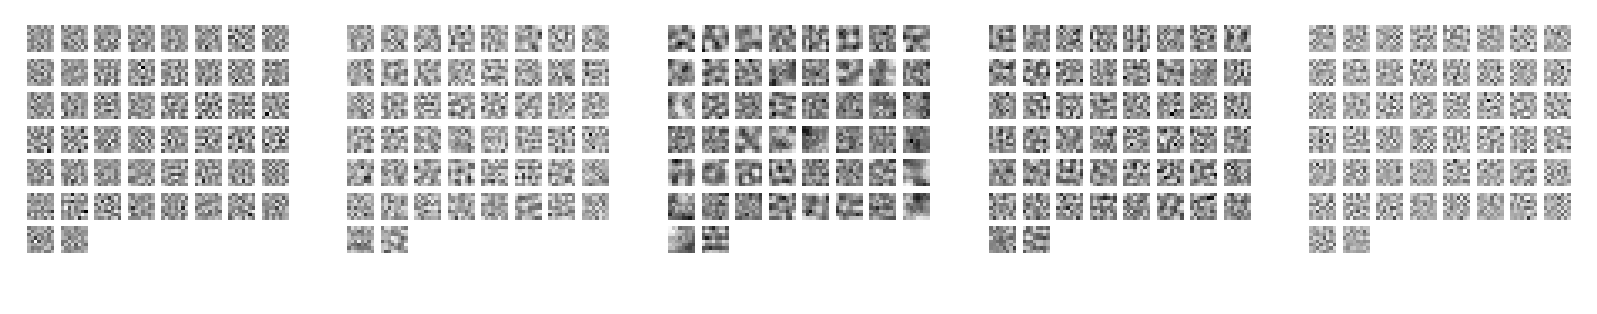

In [113]:
imp.reload(mplu)
imp.reload(plu)
print(final_inweights.shape)
mplu.plot_temporal_weights(final_inweights);

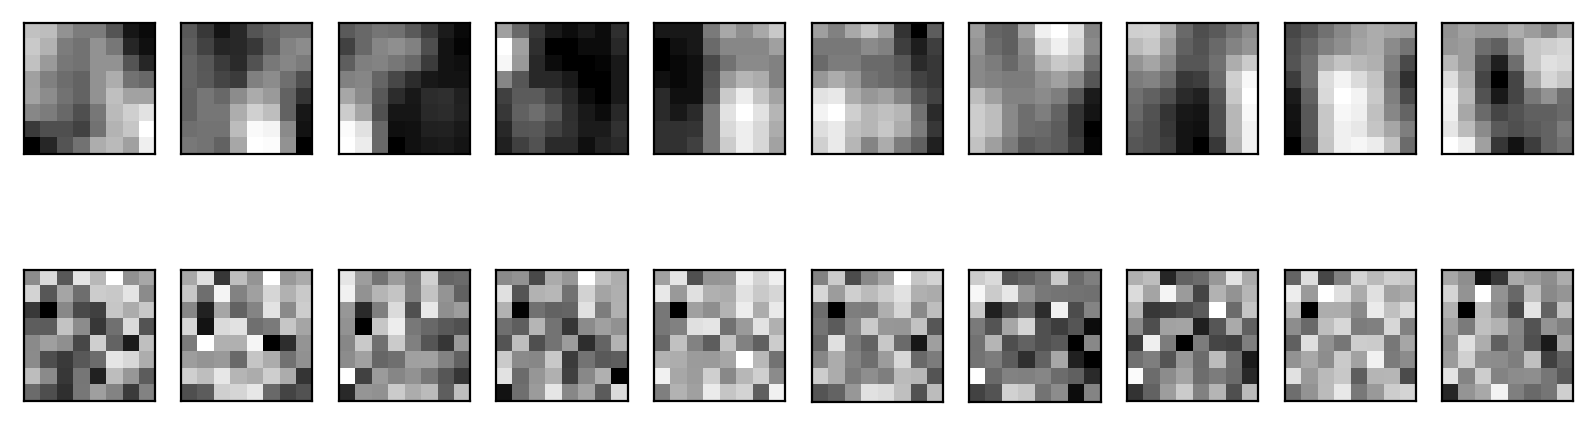

In [114]:
imp.reload(mplu)
imp.reload(plu)

randomclipindex = np.random.randint(np.shape(clips[0])[0])

mplu.plot_mov_recon(clips[0][randomclipindex],recons[0][randomclipindex],nframes=10);

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


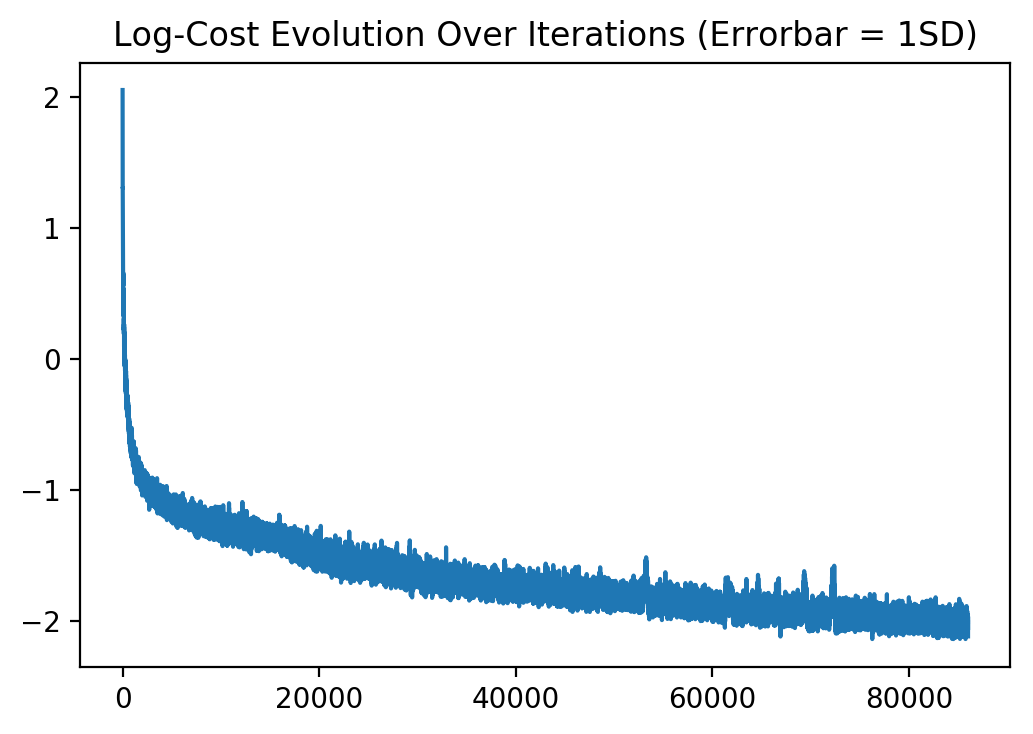

In [115]:
p = plt.errorbar(np.arange(len(cost_evolution)),
                 np.log(np.mean(np.array(cost_evolution),axis=1)),
                 yerr=np.log(np.std(np.array(cost_evolution),axis=1)));
plt.title("Log-Cost Evolution Over Iterations (Errorbar = 1SD)")

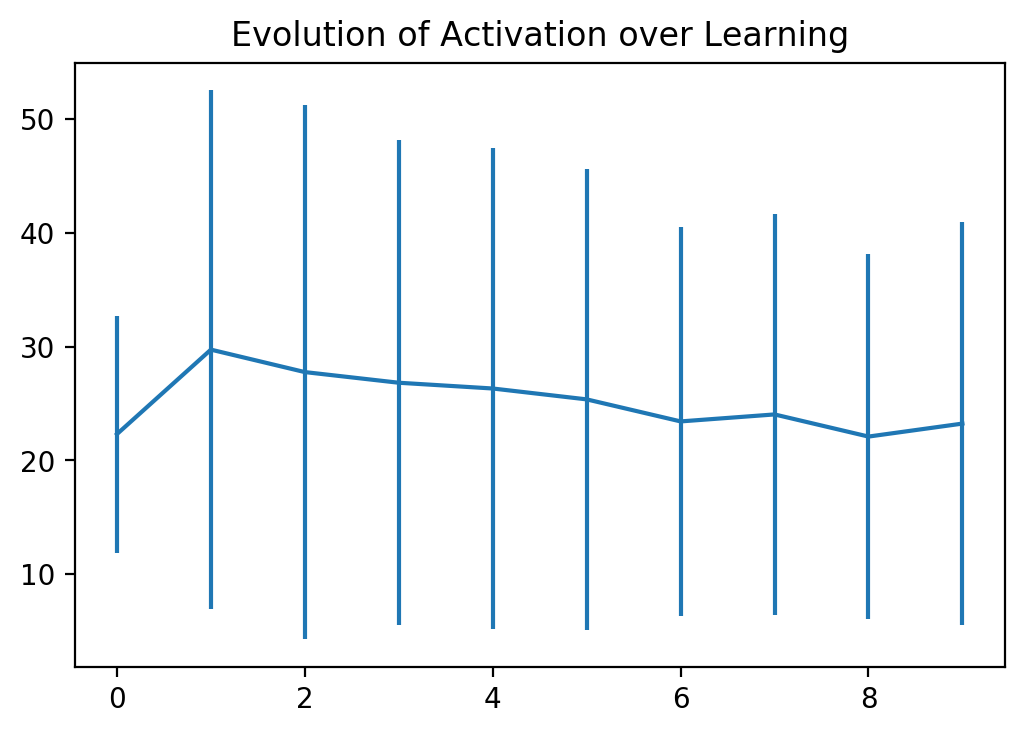

In [116]:
p = plt.errorbar(np.arange(len(activation_evolution)),
                 np.mean(np.array(activation_evolution),axis=1),
                 yerr=np.std(np.array(activation_evolution),axis=1));
plt.title('Evolution of Activation over Learning')

In [117]:

np.shape(final_inweights)

(5, 8, 8, 50)

In [66]:
np.shape(inweights_evolution)

(10, 5, 8, 8, 50)